In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

nb_steps = 150

def argmax(entry_pair):
    if abs(entry_pair[0] - entry_pair[1]) < 10**(-4):
        return(np.random.choice([0,1]))
    elif entry_pair[0] > entry_pair[1]:
        return(0)
    else:
        return(1)

In [2]:
class MDP:
    def __init__(self):
        # Total number of States and Actions
        self.nb_states = 3  # S0, S1, S2
        self.nb_actions = 2  # Left, Right
        
        # Initialize transition and reward matrices for the smaller state space
        self.MDP_T = np.zeros((self.nb_states, self.nb_states, self.nb_actions))
        self.rewards = [0,4,2]
        
        # Define state transitions for S0
        self.MDP_T[0, 1, 0] = 0.7  # From S0 to S1 with Left action
        self.MDP_T[0, 2, 0] = 0.3  
        self.MDP_T[0, 2, 1] = 0.7  # From S0 to S2 with Right action
        self.MDP_T[0, 1, 1] = 0.3  
        
        # From S1 and S2 we go to S0 with probability 1
        self.MDP_T[1, 0, 0] = 1.0  # From S1 to S0 with Left action
        self.MDP_T[1, 0, 1] = 1.0  
        self.MDP_T[2, 0, 0] = 1.0  # From S2 to S0 with Left action
        self.MDP_T[2, 0, 1] = 1.0  

        self.state = 0
        self.oldState = 0
        self.reward = 0

    def takeStep(self, action):
        self.oldState = self.state
        self.state = np.random.choice(range(self.nb_states), p=self.MDP_T[self.state,:,action])

In [3]:
class Learner:
    def __init__(self, mdp, learning_rate, discount_rate, explore_exploit):
        self.Qtable = 10**(-14) * np.random.rand(mdp.nb_states, mdp.nb_actions)
        self.alpha = learning_rate
        self.gamma = discount_rate
        self.epsilon = explore_exploit
        self.rewards = np.zeros(nb_steps)
        self.action = 0
        
    def updateQ(self, state, new_state, reward):
        qupdate = self.alpha * (reward + self.gamma * np.max(self.Qtable[new_state,:]) - self.Qtable[state, self.action])
        self.Qtable[state, self.action] += qupdate

In [4]:
class QLearner(Learner):
    def pickAction(self, state):
        if np.random.rand() < self.epsilon:
            self.action = np.random.choice([0, 1])  # 0 is Left, 1 is Right
        else:
            self.action = argmax(self.Qtable[state])

In [5]:
class MBLearner(Learner):
    def __init__(self, mdp, learning_rate, discount_rate, explore_exploit):
        Learner.__init__(self, mdp, learning_rate, discount_rate, explore_exploit)
        self.transitions = mdp.MDP_T

    def pickAction(self, state):
        if np.random.rand() < self.epsilon:
            self.action = np.random.choice([0, 1])  # 0 is Left, 1 is Right
        else:
            if state == 0:
                self.action = argmax(np.matmul(np.transpose(self.transitions[0,1:,:]), self.Qtable[range(1,3),:].max(axis=1)))
            else:
                self.action = argmax(self.Qtable[state])

    def updateQ(self, state, new_state, reward):
        Learner.updateQ(self, state, new_state, reward)

In [6]:
def run_simulation(learner, mdp, stnd_dev, seed):
    np.random.seed(seed)
    phase_length = nb_steps//3

    # Phase I
    for i in range(2*phase_length):
        learner.pickAction(mdp.state)
        mdp.takeStep(learner.action)
        if mdp.oldState == 0:
            reward = 0
        else:
            reward = np.random.normal(mdp.rewards[mdp.oldState], stnd_dev)
        learner.updateQ(mdp.oldState, mdp.state, reward)
        if reward > 0:
            learner.rewards[i//2] = reward

    # Phase II
    mdp.state = 1
    mdp.rewards[1] = 1
    mdp.MDP_T[1,1,:] = 1
    mdp.MDP_T[1,0,:] = 0
    for i in range(2*phase_length):
        learner.pickAction(mdp.state)
        mdp.takeStep(learner.action)
        reward = np.random.normal(mdp.rewards[mdp.oldState], stnd_dev)
        learner.updateQ(mdp.oldState, mdp.state, reward)
        if reward > 0:
            learner.rewards[i//2 + phase_length] = reward

    # Phase III
    mdp.state = 0
    mdp.MDP_T[1,1,:] = 0
    mdp.MDP_T[1,0,:] = 1
    for i in range(2*phase_length):
        learner.pickAction(mdp.state)
        mdp.takeStep(learner.action)
        if mdp.oldState == 0:
            reward = 0
        else:
            reward = np.random.normal(mdp.rewards[mdp.oldState], stnd_dev)        
        learner.updateQ(mdp.oldState, mdp.state, reward)
        if reward > 0:
            learner.rewards[i//2+2*phase_length] = reward

    return(learner.rewards)

In [14]:
def generate_plot(num_runs, filename, learning_rate, discount_rate, explore_exploit, stnd_dev):
    all_rewards_mf = []
    all_rewards_mb = []
    phase_length = nb_steps//3
    
    # Run simulations
    for i in range(num_runs):        
        seed = i
        
        mdp = MDP()
        mf_learner = QLearner(mdp, learning_rate, discount_rate, explore_exploit)
        rewards_mf = run_simulation(mf_learner, mdp, stnd_dev, seed)

        mdp = MDP()
        mb_learner = MBLearner(mdp, learning_rate, discount_rate, explore_exploit)
        rewards_mb = run_simulation(mb_learner, mdp, stnd_dev, seed)

        all_rewards_mf.append(rewards_mf)
        all_rewards_mb.append(rewards_mb)
        
    mean_rewards_mf = np.mean(all_rewards_mf, axis=0)
    stderr_mf = np.std(all_rewards_mf, axis=0)
    
    mean_rewards_mb = np.mean(all_rewards_mb, axis=0)
    stderr_mb = np.std(all_rewards_mf, axis=0)
    
    h_mf = 1.96 * (stderr_mf/ np.sqrt(num_runs))
    h_mb = 1.96 * (stderr_mb/ np.sqrt(num_runs))

    mean_rewards_mf1 = mean_rewards_mf[0:phase_length]
    mean_rewards_mb1 = mean_rewards_mb[0:phase_length]
    h_mf1 = h_mf[0:phase_length]
    h_mb1 = h_mb[0:phase_length]

    mean_rewards_mf3 = mean_rewards_mf[(2*phase_length):nb_steps]
    mean_rewards_mb3 = mean_rewards_mb[(2*phase_length):nb_steps]
    h_mf3 = h_mf[(2*phase_length):nb_steps]
    h_mb3 = h_mb[(2*phase_length):nb_steps]

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
    
    # Plotting the mean cumulative rewards with confidence intervals
    x = range(phase_length)
    ax1.plot(x,mean_rewards_mf1, '-', lw=1, label='MF Average Reward', color = 'darkred')
    ax1.fill_between(x, mean_rewards_mf1 - h_mf1, mean_rewards_mf1 + h_mf1, alpha=0.2, color='tomato')
    ax1.plot(x, mean_rewards_mb1, '-', lw=1, label='MB Average Reward', color = 'navy')
    ax1.fill_between(x, mean_rewards_mb1 - h_mb1, mean_rewards_mb1 + h_mb1, alpha=0.2, color='cornflowerblue')
    ax1.plot(x, 3.36*np.ones(phase_length), linestyle = "dashed", lw = 1, color = 'gray')
    ax1.set_xlim(0,phase_length)
    ax1.set_ylim(0,4)
    ax1.annotate("optimal", (0,3.4), fontsize=20, color='gray')

    x = range((2*phase_length),nb_steps)
    ax2.plot(x,mean_rewards_mf3, '-', lw=1, label='MF Average Reward', color = 'darkred')
    ax2.fill_between(x, mean_rewards_mf3 - h_mf3, mean_rewards_mf3 + h_mf3, alpha=0.2, color='tomato')
    ax2.plot(x, mean_rewards_mb3, '-', lw=1, label='MB Average Reward', color = 'navy')
    ax2.fill_between(x, mean_rewards_mb3 - h_mb3, mean_rewards_mb3 + h_mb3, alpha=0.2, color='cornflowerblue')
    ax2.plot(x, 1.68*np.ones(phase_length), linestyle = "dashed", lw = 1, color = 'gray')
    ax2.annotate("optimal", (100,1.72), fontsize=20, color = 'gray')
    ax2.set_xlim(2*phase_length,nb_steps)
    ax2.set_ylim(0,4)
    
    # Adding phase labels
    ax1.set_title('Phase I', fontsize=30)   
    ax2.set_title('Phase III', fontsize=30)

    # Adjusting labels and legend
    ax1.set_ylabel('Average Reward', fontsize=30)
    ax1.set_xlabel('Episode', fontsize=30)
    ax1.set_xticks(range(0,phase_length+1,10))
    
    ax1.legend(loc='lower left', fontsize=25)
    ax2.set_xlabel('Episode', fontsize=30)
    ax2.set_xticks(range((2*phase_length), nb_steps+1, 10))

    fig.savefig(filename,dpi=500)

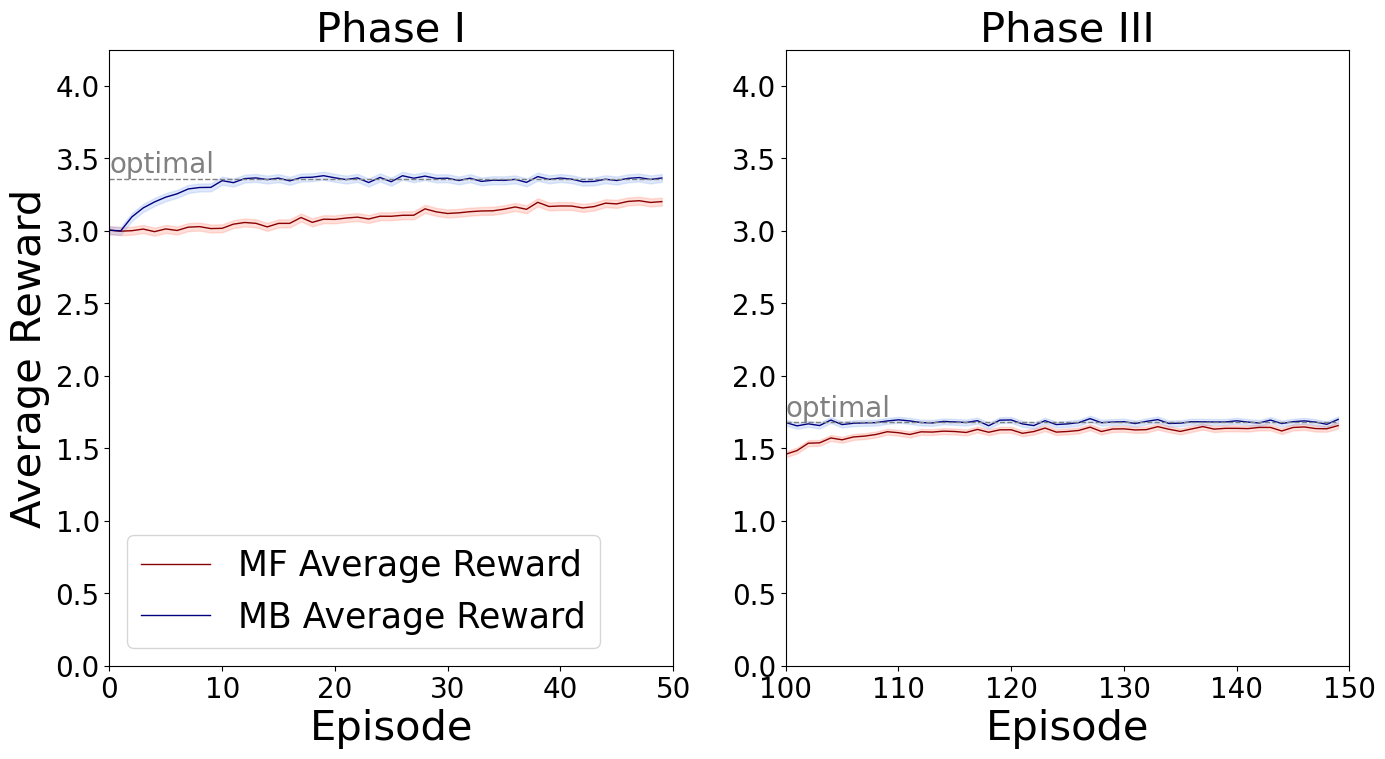

In [34]:
generate_plot(10000, f'All_Runs.png', .5, .1, .1, 1)